In [1]:
using LinearAlgebra
using PyPlot
import TensorCrossInterpolation as TCI
using QuanticsTCI
using Cubature

include("honeycomb.jl")
include("kanemele.jl")
include("latticeplot.jl")
include("berry.jl")
include("chern.jl")

rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
rcParams["text.usetex"] = true
#rcParams["text.latex.preamble"] = [r"\usepackage{lmodern}", r"\usepackage{gensymb}", r"\usepackage{amsmath}"]

function displaymatrix(A::Matrix)
    show(stdout, "text/plain", A)
end

function maxlinkdim(n::Integer, localdim::Integer=2)
    return 0:n-2, [min(localdim^i, localdim^(n - i)) for i in 1:(n-1)]
end

Did not find xfac. QTT functions will not be available.PyError (PyImport_ImportModule

The Python package xfacpy could not be imported by pyimport. Usually this means
that you did not install xfacpy in the Python version being used by PyCall.

PyCall is currently configured to use the Python version at:

/Users/Ritter.Marc/.pyenv/versions/3.8.15/bin/python

and you should use whatever mechanism you usually use (apt-get, pip, conda,
etcetera) to install the Python package containing the xfacpy module.

One alternative is to re-configure PyCall to use a different Python
version on your system: set ENV["PYTHON"] to the path/name of the python
executable you want to use, run Pkg.build("PyCall"), and re-launch Julia.

Another alternative is to configure PyCall to use a Julia-specific Python
distribution via the Conda.jl package (which installs a private Anaconda
Python distribution), which has the advantage that packages can be installed
and kept up-to-date via Julia.  As explained in the P

maxlinkdim (generic function with 2 methods)

# Haldane model

- [See Haldane PRL 1988]

The Bloch Hamiltonian is a 2x2 matrix
$$
H(\mathbf{k}) =
2t_2 \cos\phi \left[ \sum_i \cos(\mathbf{k}\cdot\mathbf{b}_i) \right] \sigma^0 +
t_1 \left[ \sum_i \cos(\mathbf{k} \cdot \mathbf{a_i}) \right] \sigma^1 +
t_1 \left[ \sum_i \sin(\mathbf{k} \cdot \mathbf{a_i}) \right] \sigma^2 +
$$
$$
+\left[m - 2t_2 \sin\phi \sum_i \sin(\mathbf{k}\cdot\mathbf{b_i}) \right] \sigma^3
$$
where $\sigma^\mu$ are Pauli matrices (with identity $\sigma^0$), $a_i$ are distance vectors between nearest neighbours and $b_i$ are between next-nearest neighbours. In the following, I set $t_1 = 1$ as unit of energy, and choose $t_2 = 0.1, \phi = \pi/2$. For this choice of parameters, the model is

 * topologically nontrivial for $|m| < 0.3\sqrt 3$ with Chern number $-1$,
 
 * trivial for $|m| > 0.3\sqrt 3$ (Chern number $0$)
 
 * and has a Dirac point for $|m| = 0.3\sqrt 3$ (Chern number $-1/2$).

Close to the transition, the gap at the dirac point is approximately $2\delta m$, where $\delta m = |m - 0.3\sqrt 3|$. Accordingly, we need a lattice with resolution $\sim \delta m$ to resolve the gap and get the correct Chern number.

In [2]:
pauli0 = [1. 0.; 0. 1.]
pauli = [
    [0. 1.; 1. 0.],
    [0. -1.0im; 1.0im 0.],
    [1. 0.; 0. -1.]
]

antisymmetricproduct(u, v) = u[1] * v[2] - u[2] * v[1]
    
function haldane(k, t2, ϕ, m)
    a::Vector{Vector{Float64}} =
    [
        [1, 0],
        [-0.5, 0.5sqrt(3)],
        [-0.5, -0.5sqrt(3)]
    ]
    b::Vector{Vector{Float64}} = [a[2] - a[3], a[3] - a[1], a[1] - a[2]]

    return 2 * t2 * cos(ϕ) * sum(cos(k' * bi) for bi in b) * pauli0 +    # NNN hopping
        sum(cos(k' * ai) * pauli[1] + sin(k' * ai) * pauli[2] for ai in a) + # NN hopping
        (m - 2 * t2 * sin(ϕ) * sum(sin(k' * bi) for bi in b)) * pauli[3]    # staggered offset
end

haldane (generic function with 1 method)

Gap ≈ 0.0019999999999997797


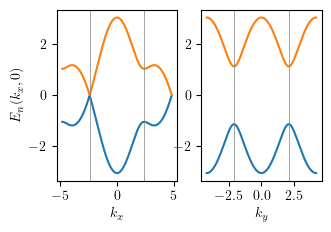

In [3]:
deltam = -0.001

t2 = 0.1 #0.1
phi = pi/2
m = 3sqrt(3) * t2 + deltam

nplot = 400

BZedgex = 4pi / 3
BZedgey = 8pi / (3sqrt(3))
kxplot = range(-BZedgex, BZedgex; length=nplot)
kyplot = range(-BZedgey, BZedgey; length=nplot)

bands = [eigvals(haldane([kx, ky], t2, phi, m)) for kx in kxplot, ky in kyplot]

fig, axs = subplots(ncols=2, figsize=(246/72, 160/72))
axs[1].plot(kyplot, bands[div(nplot, 2), :]);
axs[2].plot(kxplot, bands[:, div(nplot, 2)]);

axs[1].axvline(-4pi/(3sqrt(3)), color="gray", linewidth=0.5)
axs[1].axvline(4pi/(3sqrt(3)), color="gray", linewidth=0.5)

axs[2].axvline(-2pi / 3, color="gray", linewidth=0.5)
axs[2].axvline(2pi / 3, color="gray", linewidth=0.5)

axs[1].set_xlabel(L"$k_x$")
axs[2].set_xlabel(L"$k_y$")
axs[1].set_ylabel(L"$E_n(k_x, 0)$")

gap = minimum(b[2] for b in bands) - maximum(b[1] for b in bands)
println("Gap ≈ $gap")

Cuts through the band structure. Gray lines are boundaries of the BZ. At one of the boundaries, we almost have a dirac point. This is where the Berry curvature will be strongly peaked.

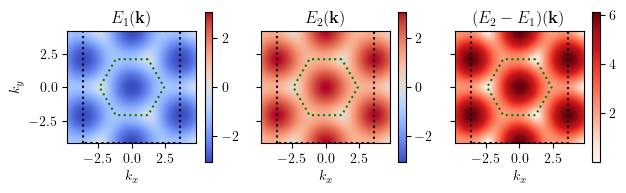

In [4]:
BZcontour = [
    [2pi / 3, 2pi/(3sqrt(3))],
    [2pi / 3, -2pi/(3sqrt(3))],
    [0, -4pi/(3sqrt(3))],
    [-2pi / 3, -2pi/(3sqrt(3))],
    [-2pi / 3, 2pi/(3sqrt(3))],
    [0, 4pi/(3sqrt(3))],
    [2pi / 3, 2pi/(3sqrt(3))],
]

intdomain = [
    [-4pi / 3, -6pi / (3sqrt(3))],
    [4pi / 3, -6pi / (3sqrt(3))],
    [4pi / 3, 6pi / (3sqrt(3))],
    [-4pi / 3, 6pi / (3sqrt(3))],
    [-4pi / 3, -6pi / (3sqrt(3))],
]

fig, axs = subplots(ncols=3, sharey=true, figsize=(510/72, 140/72))

vmax = maximum([maximum(abs.(b)) for b in bands])
extent = [-BZedgey, BZedgey, -BZedgex, BZedgex]
intextent = [-2pi/sqrt(3), 2pi/sqrt(3), -4pi/3, 4pi/3]

axs[1].imshow([b[1] for b in bands], cmap="coolwarm", vmin=-vmax, vmax=vmax, extent=extent) |> colorbar
axs[2].imshow([b[2] for b in bands], cmap="coolwarm", vmin=-vmax, vmax=vmax, extent=extent) |> colorbar
axs[3].imshow([b[2] - b[1] for b in bands], cmap="Reds", extent=extent) |> colorbar

for ax in axs
    ax.plot(
        [y for (x, y) in BZcontour],
        [x for (x, y) in BZcontour],
        "g:"
    )
    ax.plot(
        [y for (x, y) in intdomain],
        [x for (x, y) in intdomain],
        "k:"
    )
end

axs[1].set_title(L"$E_1(\mathbf{k})$")
axs[2].set_title(L"$E_2(\mathbf{k})$")
axs[3].set_title(L"$(E_2 - E_1)(\mathbf{k})$")

axs[1].set_ylabel(L"$k_y$")
axs[1].set_xlabel(L"$k_x$")
axs[2].set_xlabel(L"$k_x$")
axs[3].set_xlabel(L"$k_x$");

Band structure and gap as a function of $\mathbf k$. The green hexagon is the first BZ. Since we integrate over a rectangle, I will assemble parts of multiple BZ to a rectangular integration domain (black) and then divide by 4 to account for the increased volume.

Chern number from direct sum: -0.8750000000000004


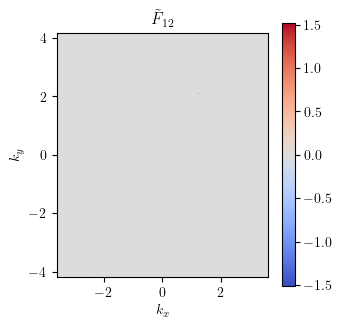

In [5]:
domainboundx = [-4pi/3, 4pi/3]
domainboundy = [-6pi/(3sqrt(3)), 6pi/(3sqrt(3))]
kxdirect = range(domainboundx...; length=nplot)
kydirect = range(domainboundy...; length=nplot)

fig, axs = subplots(figsize=(246/72, 246/72))
A = chern.berrycurvature_dets([haldane([kx, ky], t2, phi, m) for kx in kxdirect, ky in kydirect], 2)
vmax = maximum(abs.(A))
axs.imshow(A, cmap="coolwarm", vmin=-vmax, vmax=vmax, extent=intextent) |> colorbar

axs.set_title(L"$\tilde F_{12}$")
axs.set_xlabel(L"$k_x$")
axs.set_ylabel(L"$k_y$")

println("Chern number from direct sum: $(sum(A) / 2pi / 4)")

This is the Berry curvature; unfortunately, it is so strongly peaked that a linear plot seems blank (log plot below). For direct evaluation, I cannot afford a very large lattice. As I'm summing over 4 copies of the BZ, there should be 4 peaks with a contribution of -1 each. Due to insufficient resolution, some of the peaks only contribute -0.5 to the sum, and after dividing by 4, the resulting Chern number is incorrect.

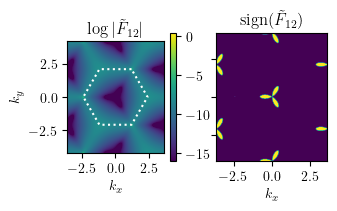

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x13aa14eb0>

In [6]:
fig, axs = subplots(ncols=2, sharey=true, figsize=(246/72, 120/72))
axs[1].imshow(log.(abs.(A)), vmin=-16, extent=intextent) |> colorbar
axs[2].imshow(sign.(A), extent=intextent)

axs[1].set_title(L"$\log|\tilde{F}_{12}|$")
axs[2].set_title(L"$\mathrm{sign}(\tilde{F}_{12})$")
axs[1].set_xlabel(L"$k_x$")
axs[2].set_xlabel(L"$k_x$")
axs[1].set_ylabel(L"$k_y$");

axs[1].plot(
    [y for (x, y) in BZcontour],
    [x for (x, y) in BZcontour],
    "w:"
)

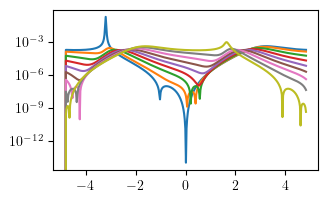

In [7]:
fig, axs = subplots(figsize=(246/72, 150/72))

step = div(nplot, 32)
quarter = div(nplot, 4)
axs.semilogy(kyplot, abs.(A[2*quarter+1:step:3*quarter+1, :]'));

# QTCI rep

With QTCI, we can do better. As the gap has order $\delta m \approx 10^{-3}$, I need more than $10^3$ points; accordingly, I choose $N = 12$.

In [8]:
nquantics = 12
ndiscretization = 2^nquantics
kxvals = range(domainboundx..., length=ndiscretization)
kyvals = range(domainboundy..., length=ndiscretization)


function sumqtt(qtt)
    return prod(sum(T, dims=2)[:, 1, :] for T in qtt)[1]
end

function crossinterpolate_chern(
    ::Type{ValueType},
    f,
    localdims::Vector{Int},
    firstpivot::TCI.MultiIndex=ones(Int, length(localdims));
    tolerance::Float64=1e-8,
    maxiter::Int=200,
    sweepstrategy::TCI.SweepStrategies.SweepStrategy=TCI.SweepStrategies.back_and_forth,
    pivottolerance::Float64=1e-12,
    errornormalization::Union{Nothing,Float64}=nothing,
    verbosity::Int=0
) where {ValueType}
    tci = TCI.TensorCI{ValueType}(f, localdims, firstpivot)
    n = length(tci)
    errors = Float64[]
    cherns = Float64[]
    ranks = Int[]
    N::Float64 = isnothing(errornormalization) ? abs(f(firstpivot)) : abs(errornormalization)

    # Start at two, because the constructor already added a pivot everywhere.
    for iter in 2:maxiter
        foward_sweep = (
            sweepstrategy == TCI.SweepStrategies.forward ||
            (sweepstrategy != TCI.SweepStrategies.backward && isodd(iter))
        )

        if foward_sweep
            TCI.addpivot!.(tci, 1:n-1, f, pivottolerance)
        else
            TCI.addpivot!.(tci, (n-1):-1:1, f, pivottolerance)
        end

        push!(errors, TCI.lastsweeppivoterror(tci) / N)
        push!(ranks, maximum(rank(tci)))
        push!(cherns, sumqtt(TCI.tensortrain(tci))  / 2pi)

        if verbosity > 0 && mod(iter, 10) == 0
            println("rank= $(last(ranks)) , error= $(last(errors))")
        end
        if last(errors) < tolerance
            break
        end
    end

    return tci, ranks, errors, cherns
end

f(q) = chern.berrycurvature_quantics_dets(
    kindex -> haldane([kxvals[kindex[1]], kyvals[kindex[2]]], t2, phi, m),
    2, q, nquantics)

firstpivot = TCI.optfirstpivot(f, fill(2, 2*nquantics), [1, 1, fill(2, 2*nquantics-2)...])
walltime = @elapsed tci, ranks, errors, cherns = crossinterpolate_chern(
    Float64,
    f,
    fill(2, 2 * nquantics),
    firstpivot,
    tolerance=1e-4,
    maxiter=200
);

println("walltime: $walltime")

walltime: 83.770630667


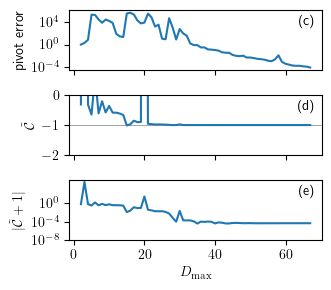

In [9]:
fig, axs = subplots(nrows=3, sharex=true, figsize=[246/72, 300/100])

axs[1].semilogy(ranks, errors)
axs[1].set_ylabel("pivot error")
axs[1].set_yticks(10. .^ [4, 0, -4])

for c in [-1, 0, 1]
    axs[2].axhline(c, color="gray", linewidth=0.5)
end
axs[2].plot(ranks, cherns ./ 4)
axs[2].set_ylabel(L"$\tilde{\mathcal{C}}$")
axs[2].set_ylim(-2, 0)

axs[3].semilogy(ranks, abs.(cherns ./ 4 .+ 1))
axs[3].set_ylabel(L"$|\tilde{\mathcal{C}}+1|$")
axs[3].set_yticks(10. .^ [0, -4, -8])

axs[3].set_xlabel(L"$D_{\max}$")

for (ax, label) in zip(axs, ["(c)", "(d)", "(e)"])
    ax.annotate(
        label,
        xy=(1, 1),
        xycoords="axes fraction",
        horizontalalignment="right",
        verticalalignment="top",
        xytext=(-4, -4),
        textcoords="offset points"
    );
end

tight_layout()

fig.savefig("haldane-convergence.pdf")

At bond dimension $\approx 40$, the result is converged very well. Note that this QTCI is nontrivial: We have multiple copies of the BZ, and we're asking TCI to find all of the peaks. And it does, because the peaks are not infinitely sharp.

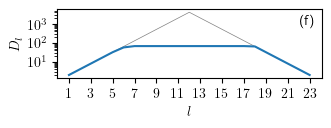

In [10]:
fig, axs = subplots(figsize=(246/72, 100/72))
axs.semilogy(1:2nquantics-1, maxlinkdim(2nquantics, 2)[2], color="gray", linewidth=0.5)
axs.semilogy(1:2nquantics-1, TCI.linkdims(tci))
axs.set_ylabel(L"$D_l$")
axs.set_xlabel(L"$l$")
axs.set_xticks(1:2:2nquantics-1);
axs.annotate(
    "(f)",
    xy=(1, 1),
    xycoords="axes fraction",
    horizontalalignment="right",
    verticalalignment="top",
    xytext=(-4, -4),
    textcoords="offset points"
);

tight_layout()

fig.savefig("haldane-Dl.pdf")

In [11]:
function scalar(a::Matrix)
    if size(a) == (1, 1)
        return first(a)
    else
        throw(ArgumentError("$a is not a scalar."))
    end
end

function evaluate_qtt(qtt, q::Vector{<:Integer})
    return scalar(prod(T[:, i, :] for (T, i) in zip(qtt, q)))
end

nplot = 1024
plotstep = div(ndiscretization, nplot)

qtt = TCI.tensortrain(tci)
qttdata = [
    evaluate_qtt(qtt, interleave_dimensions(index_to_quantics(kxi, nquantics), index_to_quantics(kyi, nquantics)))
    for kxi in 1:plotstep:length(kxvals), kyi in 1:plotstep:length(kyvals)
];

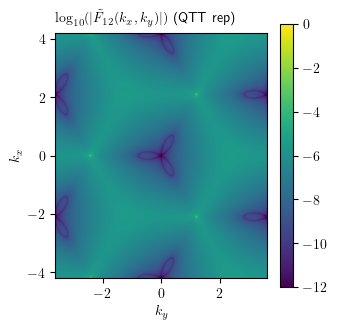

In [12]:
plottransform2(x) = log10(abs(x))
cmap = "viridis"

vmin = max(
    min(minimum(plottransform2.(qttdata))...),
    -12)
vmax = max(0, maximum.(plottransform2.(qttdata))...)


fig, axs = subplots(figsize=(246/72, 246/72))
axs.imshow(plottransform2.(qttdata), cmap=cmap, vmin=vmin, vmax=vmax, extent=intextent) |> colorbar

axs.annotate(
    L"$\log_{10}(|\tilde{F}_{12}(k_x, k_y)|)$ (QTT rep)",
    xy=(0, 1),
    xycoords="axes fraction",
    xytext=(0, 8),
    textcoords="offset points"
)

axs.set_ylabel(L"$k_x$")
axs.set_xlabel(L"$k_y$");

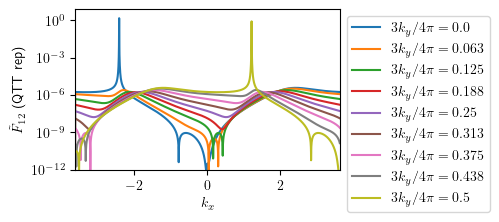

In [13]:
fig, axs = subplots(figsize=(246/72, 150/72))

step = div(ndiscretization, 32)
quarter = div(ndiscretization, 4)
for kxi in 2*quarter+1:step:3*quarter+1
    data = [
        evaluate_qtt(qtt, interleave_dimensions(index_to_quantics(kxi, nquantics), index_to_quantics(kyi, nquantics)))
        for kyi in 1:ndiscretization
    ]
    axs.semilogy(kyvals, abs.(data), label="\$3k_y/4\\pi=$(round(kxvals[kxi] * 0.75 / pi; digits=3))\$")
end

axs.set_xlim(kyvals[1], kyvals[end])
axs.set_ylim(1e-12, axs.get_ylim()[2])
axs.set_xlabel(L"$k_x$")
axs.set_ylabel(L"$\tilde F_{12}$ (QTT rep)")
axs.legend(bbox_to_anchor=(1, 1), loc="upper left");

Cuts through the BZ. The peaks are 6 orders of magnitude larger than the background. (This plot is different than the first one due to different lattice size.)

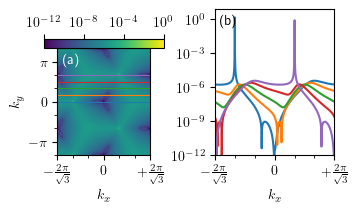

In [14]:
plottransform2(x) = log10(abs(x))
cmap = "viridis"

vmin = max(
    min(minimum(plottransform2.(qttdata))...),
    -12)
vmax = max(0, maximum.(plottransform2.(qttdata))...)

fig = figure(figsize=(246/72, 140/72))
ax_contourplot = fig.add_axes((0.1, 0.25, 0.35, 0.55))
ax_colorbar =    fig.add_axes((0.1, 0.8, 0.35, 0.05))
ax_lineplot =    fig.add_axes((0.6, 0.25, 0.35, 0.75))

contourplot = ax_contourplot.imshow(
    plottransform2.(qttdata),
    cmap=cmap, vmin=vmin, vmax=vmax, extent=intextent)
colorbar(contourplot, cax=ax_colorbar, orientation="horizontal")
ax_colorbar.tick_params(top=true, labeltop=true, bottom=false, labelbottom=false)
ax_colorbar.set_xticks([-12, -8, -4, 0], [L"$10^{-12}$", L"$10^{-8}$", L"$10^{-4}$", L"$10^0$"])

ax_contourplot.set_ylabel(L"$k_y$")
ax_contourplot.set_xlabel(L"$k_x$")

step = div(ndiscretization, 16)
quarter = div(ndiscretization, 4)
for kxi in 2*quarter+1:step:3*quarter+1
    data = [
        evaluate_qtt(qtt, interleave_dimensions(index_to_quantics(kxi, nquantics), index_to_quantics(kyi, nquantics)))
        for kyi in 1:ndiscretization
    ]
    line = ax_lineplot.semilogy(kyvals, abs.(data))[1]
    ax_contourplot.axhline(kxvals[kxi], color=line.get_color(), linewidth=0.75)
end

ax_lineplot.set_xlim(kyvals[1], kyvals[end])
ax_lineplot.set_ylim(1e-12, axs.get_ylim()[2])
ax_lineplot.set_xlabel(L"$k_x$")
#ax_lineplot.set_ylabel(L"$\tilde F_{12}$ (QTT rep)")
#ax_lineplot.legend(bbox_to_anchor=(1, 1), loc="upper left");

ax_contourplot.set_yticks(
    minor=true,
    [-4pi/3, -2pi/3, -pi/3, 0, pi/3, 2pi/3, 4pi/3]
)
ax_contourplot.set_yticks(
    [-pi, 0, pi],
    [L"$-\pi$", L"$0$", L"$\pi$"]
)

for ax in [ax_contourplot, ax_lineplot]
    ax.set_xticks(
        minor=true,
        [-4pi/(3sqrt(3)), -2pi/(3sqrt(3)), 0, 4pi/(3sqrt(3)), 2pi/(3sqrt(3))]
    )
    ax.set_xticks(
        [-2pi/(sqrt(3)), 0, 2pi/(sqrt(3))],
        [L"$-\frac{2\pi}{\sqrt{3}}$", L"$0$", L"$+\frac{2\pi}{\sqrt{3}}$"]
    )
end

ax_contourplot.annotate(
    "(a)",
    xy=(0, 1),
    xycoords="axes fraction",
    horizontalalignment="left",
    verticalalignment="top",
    xytext=(4, -4),
    textcoords="offset points",
    color="white"
);

ax_lineplot.annotate(
    "(b)",
    xy=(0, 1),
    xycoords="axes fraction",
    horizontalalignment="left",
    verticalalignment="top",
    xytext=(4, -4),
    textcoords="offset points"
);

fig.savefig("haldane-berry.pdf")